In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.style.use('ggplot') 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [27]:
root_path = '~/.kaggle/competitions/competitive-data-science-predict-future-sales/'
items  = pd.read_csv(root_path + 'items.csv')
train = pd.read_csv(root_path + 'sales_train.csv')
test = pd.read_csv(root_path + 'test.csv')
item_category = pd.read_csv(root_path + 'item_categories.csv')
shops = pd.read_csv(root_path + 'shops.csv')

In [28]:
# -1 and 307980 looks like outliers, let's delete them
print('before train shape:', train.shape)
train = train[(train.item_price > 0) & (train.item_price < 300000)]
print('after train shape:', train.shape)

before train shape: (2935849, 6)
after train shape: (2935847, 6)


In [4]:
unresanable_data(train['item_price'])
count_price = train.item_price.value_counts().sort_index(ascending=False)
plt.subplot(221)
count_price.hist(figsize=(20,6))
plt.xlabel('Item Price', fontsize=20);
plt.title('Original Distiribution')

plt.subplot(222)
train.item_price.map(np.log1p).hist(figsize=(20,6))
plt.xlabel('Item Price');
plt.title('log1p Transformation')
train.loc[:,'item_price'] = train.item_price.map(np.log1p)

NameError: name 'unresanable_data' is not defined

Text(0.5,1,'Original Distiribution')

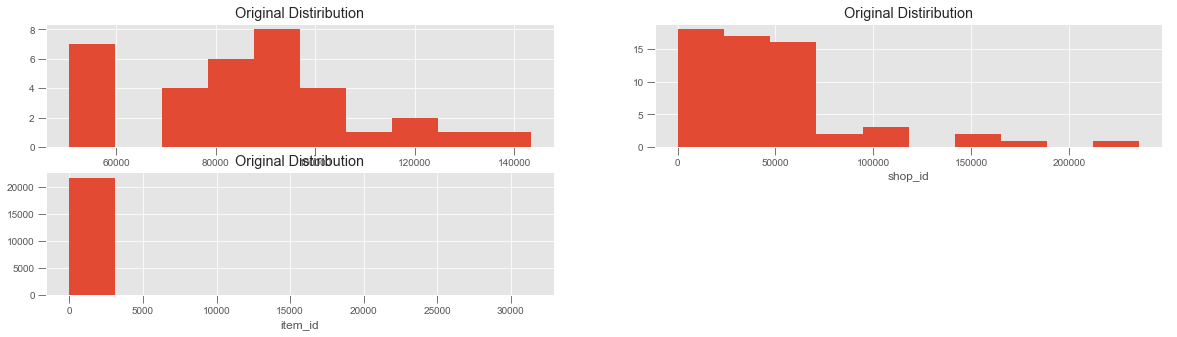

In [29]:
# unresanable_data(train['date_block_num'])
count_price = train.date_block_num.value_counts().sort_index(ascending=False)
plt.subplot(221)
count_price.hist(figsize=(20,5))
plt.xlabel('Date Block');
plt.title('Original Distiribution')

count_price = train.shop_id.value_counts().sort_index(ascending=False)
plt.subplot(222)
count_price.hist(figsize=(20,5))
plt.xlabel('shop_id');
plt.title('Original Distiribution')

count_price = train.item_id.value_counts().sort_index(ascending=False)
plt.subplot(223)
count_price.hist(figsize=(20,5))
plt.xlabel('item_id');
plt.title('Original Distiribution')



# Map the Items

In [30]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [31]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [32]:
items.merge(item_category[['item_category_id']], how="inner", on="item_category_id")[['item_id','item_category_id']].head()

,item_id,item_category_id
0,0,40
1,2,40
2,3,40
3,4,40
4,5,40


# Convert Date Column data type from object to Date 

In [33]:
train['date'] = pd.to_datetime(train.date,format="%d.%m.%Y")
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [34]:
## Pivot by monht to wide format
p_df = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [35]:
## Join with categories
train_cleaned_df = p_df.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

item_to_cat_df = items.merge(item_category[['item_category_id']], how="inner", on="item_category_id")[['item_id','item_category_id']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

# Encode Categories
from sklearn import preprocessing

train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'item_category_id'] + list(range(34))]
train_cleaned_df.head()

,shop_id,item_id,item_category_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,40,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,40,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,40,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,40,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Building

In [36]:
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

1.24958071127


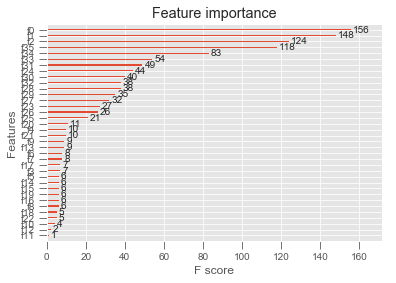

In [37]:
xgb.plot_importance(bst)

In [38]:
apply_df = test
apply_df['shop_id']= apply_df.shop_id.astype('str')
apply_df['item_id']= apply_df.item_id.astype('str')

apply_df = test.merge(train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,item_category_id,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
apply_df.head()

,ID,shop_id,item_id,item_category_id,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != 33)].values))

In [41]:
# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.274975
std,61834.358168,0.682610
min,0.000000,0.000000
25%,53549.750000,0.109826
50%,107099.500000,0.183396
75%,160649.250000,0.203652
max,214199.000000,20.000000


In [42]:
sub_df.to_csv('Submission_Predict Sales.csv',index=False)